# Introduction to text embeddings on S&P 500 news

objectives# 📌 Objectives

By the end of this notebook, students will be able to:

1. **Retrieve Financial News:**
   - Use the `yfinance` library to gather news headlines for all companies in the S&P 500 index.

2. **Clean and Structure Financial Text Data:**
   - Extract and organize relevant metadata (e.g., ticker, title, summary, publication date, URL) into a structured pandas DataFrame.

3. **Generate Text Embeddings:**
   - Apply a pre-trained sentence transformer model (`all-MiniLM-L6-v2`) to convert news headlines and summaries into numerical embeddings.

4. **Apply Clustering Techniques:**
   - Use K-Means clustering to identify groups of similar news articles based on semantic content.

5. **Determine Optimal Number of Clusters:**
   - Evaluate clustering quality using silhouette scores to find the best number of clusters.

6. **Visualize High-Dimensional Embeddings:**
   - Reduce the embedding space using PCA and visualize clusters in two dimensions.

7. **Interpret Cluster Themes:**
   - Analyze representative news


## Install and Import important librairies

In [ ]:
%pip install pandas
%pip install yfinance
%pip install lxml
%pip install -U sentence-transformers

In [ ]:
from sentence_transformers import SentenceTransformer
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer
import pandas as pd
from sklearn.metrics import silhouette_score
import yfinance as yf

C:\Users\danie\source\tec\itesm-mna-fintech\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Get the list of stocks in the S&P 500

In [ ]:
# Read and print the stock tickers that make up S&P500
df_tickers = pd.read_html(
    'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]

display(df_tickers.head())

,Symbol,Security,GICS Sector,GICS Sub-Industry,Headquarters Location,Date added,CIK,Founded
0,MMM,3M,Industrials,Industrial Conglomerates,"Saint Paul, Minnesota",1957-03-04,66740,1902
1,AOS,A. O. Smith,Industrials,Building Products,"Milwaukee, Wisconsin",2017-07-26,91142,1916
2,ABT,Abbott Laboratories,Health Care,Health Care Equipment,"North Chicago, Illinois",1957-03-04,1800,1888
3,ABBV,AbbVie,Health Care,Biotechnology,"North Chicago, Illinois",2012-12-31,1551152,2013 (1888)
4,ACN,Accenture,Information Technology,IT Consulting & Other Services,"Dublin, Ireland",2011-07-06,1467373,1989


In [ ]:
ticker_list = df_tickers['Symbol'].tolist()

## Get the news of all 500 stocks in the S&P 500 Index
Use the yfinance library to retrieve the news of all 500 stocks in the index.
https://ranaroussi.github.io/yfinance/reference/yfinance.stock.html

### Get the news in a dictionary

In [ ]:
news_by_ticker = {ticker: yf.Ticker(ticker).news for ticker in ticker_list}

### Structure the news into a pandas dataframe

Your final dataframe should have the following columns:
- TICKER
- TITLE (of the news)
- SUMMARY (of the news)
- PUBLICATION_DATE (of the news)
- URL (of the news)

Note: all of those fields are provided in the yfinance news component. Refer to the library documentation.

In [ ]:
def map_to_row(ticker, article):
    return {
        'TICKER': ticker,
        'TITLE': article['content']['title'],
        'SUMMARY': article['content']['summary'],
        'PUBLICATION_DATE': article['content']['pubDate'],
        'URL': article['content']['canonicalUrl']['url']
    }

data = []
for ticker, articles in news_by_ticker.items():
    for a in articles:
        if a['content'] is not None:
            data.append(map_to_row(ticker, a))

df_news = pd.DataFrame(data)

In [ ]:
df_news.describe()

,TICKER,TITLE,SUMMARY,PUBLICATION_DATE,URL
count,5008,5008,5008,5008,5008
unique,501,4134,3940,3790,4193
top,ZTS,"Stocks Rise Pre-Bell as US, EU Strike Trade De...","Wondering how to pick strong, market-beating s...",2025-07-28T11:26:19Z,https://finance.yahoo.com/news/stocks-rise-pre...
freq,10,14,37,14,14


## Exploring text embeddings

- Use the open-source model: 'sentence-transformers/all-MiniLM-L6-v2' to create embeddings on the news title and summary
- You should combine the title and summary into one string that you will embed together
- Add a column to your news dataframe called EMBEDDED_TEXT using ONLY the TITLE of the news
- Add a column to your news dataframe called EMBEDDINGS, which contains the embedding of EMBEDDED_TEXT


In [ ]:
# Loads the pre-trained sentence transformer model
model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

In [ ]:
df_news['EMBEDDED_TEXT'] = df_news['TITLE']

In [ ]:
# Run the model to encode the text into embeddings
embeddings = model.encode(df_news['EMBEDDED_TEXT'].tolist())

In [ ]:
display(embeddings.shape)

(5008, 384)

In [ ]:
df_news['EMBEDDINGS'] = embeddings.tolist()

In [ ]:
display(df_news.head())

,TICKER,TITLE,SUMMARY,PUBLICATION_DATE,URL,EMBEDDED_TEXT,EMBEDDINGS
0,MMM,3M Company (MMM): “I Was Surprised” By The Org...,We recently published 12 Stocks Jim Cramer Tal...,2025-07-24T09:03:00Z,https://finance.yahoo.com/news/3m-company-mmm-...,3M Company (MMM): “I Was Surprised” By The Org...,"[0.00645541911944747, -0.1090475395321846, -0...."
1,MMM,"Zacks Industry Outlook Highlights Honeywell, 3...","HON, MMM, CSL, and FSS are well-positioned to ...",2025-07-21T09:45:00Z,https://finance.yahoo.com/news/zacks-industry-...,"Zacks Industry Outlook Highlights Honeywell, 3...","[-0.02162928320467472, -0.07978317141532898, -..."
2,MMM,"Stock Market News for Jul 21, 2025",U.S. stock markets closed mostly lower n Frida...,2025-07-21T08:22:00Z,https://finance.yahoo.com/news/stock-market-ne...,"Stock Market News for Jul 21, 2025","[-0.037469569593667984, -0.04381373152136803, ..."
3,MMM,3M Co (MMM) Q2 2025 Earnings Call Highlights: ...,3M Co (MMM) reports a 12% increase in adjusted...,2025-07-19T07:05:47Z,https://finance.yahoo.com/news/3m-co-mmm-q2-20...,3M Co (MMM) Q2 2025 Earnings Call Highlights: ...,"[-0.08080148696899414, -0.02980075404047966, -..."
4,MMM,MMM Q1 Deep Dive: Tariffs Loom Over Stable Ope...,Industrial conglomerate 3M (NYSE:MMM) reported...,2025-07-19T05:30:58Z,https://finance.yahoo.com/news/mmm-q1-deep-div...,MMM Q1 Deep Dive: Tariffs Loom Over Stable Ope...,"[-0.01950262300670147, -0.07280385494232178, 0..."


## Using K-means clustering on news embeddings
to simplify, keep only one news for each company (ticker), you should have 500 rows in your news dataframe

In [ ]:
df_news_filtered = df_news.drop_duplicates(subset=['TICKER']).reset_index(drop=True)

df_news_filtered.describe()

,TICKER,TITLE,SUMMARY,PUBLICATION_DATE,URL,EMBEDDED_TEXT,EMBEDDINGS
count,501,501,501,501,501,501,501
unique,501,426,411,397,428,426,436
top,ZTS,"Federal Reserve meeting, July jobs report, and...",The stock market is at record highs as investo...,2025-07-27T11:37:56Z,https://finance.yahoo.com/news/federal-reserve...,"Federal Reserve meeting, July jobs report, and...","[-0.018141131848096848, -0.02313668094575405, ..."
freq,1,9,9,9,9,9,9


In [ ]:
k_means = KMeans(random_state=42)
r = k_means.fit_predict(df_news_filtered['EMBEDDINGS'].tolist())

In [ ]:
r

array([2, 4, 2, 3, 7, 1, 6, 3, 4, 3, 1, 6, 3, 7, 7, 2, 3, 3, 3, 6, 6, 4,
       5, 3, 6, 1, 2, 3, 3, 3, 6, 3, 7, 4, 7, 5, 4, 2, 5, 4, 6, 3, 7, 3,
       3, 3, 1, 3, 3, 3, 4, 3, 1, 2, 3, 3, 5, 0, 3, 2, 3, 6, 3, 4, 2, 4,
       4, 3, 5, 6, 6, 3, 1, 7, 4, 3, 3, 3, 3, 2, 3, 3, 3, 3, 1, 1, 3, 2,
       2, 3, 2, 3, 2, 3, 4, 6, 4, 5, 5, 2, 7, 6, 2, 3, 5, 5, 1, 1, 3, 1,
       3, 7, 4, 5, 2, 5, 1, 7, 1, 2, 6, 3, 3, 3, 1, 4, 2, 1, 3, 6, 5, 4,
       3, 4, 3, 0, 3, 4, 1, 4, 6, 2, 4, 6, 6, 3, 3, 4, 6, 3, 6, 2, 5, 2,
       4, 1, 7, 6, 3, 3, 3, 1, 3, 2, 2, 3, 1, 2, 4, 3, 3, 4, 6, 4, 4, 4,
       3, 6, 3, 3, 1, 2, 0, 4, 3, 5, 6, 0, 1, 5, 7, 4, 2, 1, 1, 3, 3, 3,
       6, 3, 2, 2, 3, 2, 2, 2, 2, 6, 6, 7, 3, 3, 6, 5, 2, 6, 2, 4, 3, 1,
       3, 3, 4, 1, 3, 1, 1, 3, 2, 3, 2, 1, 7, 3, 3, 6, 3, 3, 7, 3, 6, 3,
       6, 3, 3, 3, 6, 4, 3, 1, 3, 3, 6, 6, 4, 3, 2, 5, 3, 6, 2, 1, 2, 3,
       2, 1, 7, 3, 1, 3, 2, 7, 7, 2, 3, 4, 4, 3, 7, 3, 4, 4, 4, 3, 3, 2,
       1, 3, 7, 6, 4, 4, 2, 3, 5, 4, 4, 1, 1, 4, 6,

### Identify the number of clusters using the silhouette score

- Using a for loop, do the clustering with different k values (number of clusters), test 1 to 6 clusters
- Compute the silhouette score for every k value
- Plot the silhouette score for different k values

#### Try different values of k and compute silhouette scores

In [ ]:
silhouette_by_n_clusters = {}

for i in range(2, 7):
    k_means = KMeans(n_clusters=i, random_state=42)
    labels = k_means.fit_predict(df_news_filtered['EMBEDDINGS'].tolist())
    silhouette_avg = silhouette_score(df_news_filtered['EMBEDDINGS'].tolist(), labels)
    silhouette_by_n_clusters[i] = silhouette_avg
    print(f"n_clusters = {i}, silhouette score = {silhouette_avg:.4f}")

n_clusters = 2, silhouette score = 0.0541
n_clusters = 3, silhouette score = 0.0563
n_clusters = 4, silhouette score = 0.0519
n_clusters = 5, silhouette score = 0.0345
n_clusters = 6, silhouette score = 0.0382


#### Plot silhouette scores

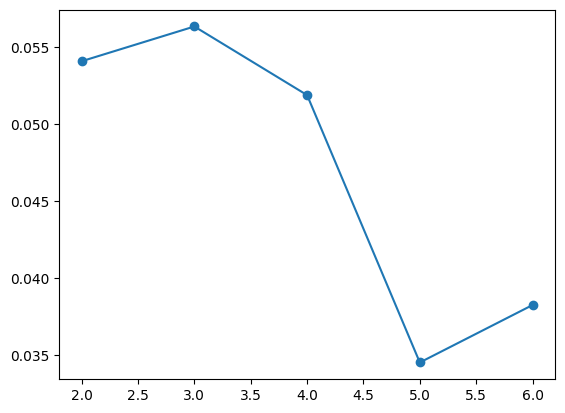

In [ ]:
plt.plot(list(silhouette_by_n_clusters.keys()), list(silhouette_by_n_clusters.values()), marker='o')

#### Identify the Best k

In [ ]:
print(f"Best k is {max(silhouette_by_n_clusters, key=silhouette_by_n_clusters.get)} with silhouette score = {max(silhouette_by_n_clusters.values()):.4f}")

Best k is 3 with silhouette score = 0.0563


#### Cluster the embeddings using 3 clusters (k=3)

In [ ]:
k_means = KMeans(n_clusters=3, random_state=42)

clusters = k_means.fit_predict(df_news_filtered['EMBEDDINGS'].tolist())

df_news_filtered['CLUSTER'] = clusters

display(df_news_filtered.head())

,TICKER,TITLE,SUMMARY,PUBLICATION_DATE,URL,EMBEDDED_TEXT,EMBEDDINGS,CLUSTER
0,MMM,3M Company (MMM): “I Was Surprised” By The Org...,We recently published 12 Stocks Jim Cramer Tal...,2025-07-24T09:03:00Z,https://finance.yahoo.com/news/3m-company-mmm-...,3M Company (MMM): “I Was Surprised” By The Org...,"[0.00645541911944747, -0.1090475395321846, -0....",0
1,AOS,Here's Why A.O. Smith (AOS) is a Strong Value ...,"Wondering how to pick strong, market-beating s...",2025-07-28T13:40:03Z,https://finance.yahoo.com/news/heres-why-o-smi...,Here's Why A.O. Smith (AOS) is a Strong Value ...,"[-0.05186045542359352, -0.04412436485290527, -...",2
2,ABT,Revvity trims 2025 profit forecast as China po...,(Reuters) -Revvity on Monday lowered its full-...,2025-07-28T12:09:43Z,https://finance.yahoo.com/news/revvity-trims-2...,Revvity trims 2025 profit forecast as China po...,"[0.00020878251234535128, -0.009514638222754002...",0
3,ABBV,Pre-Q2 Earnings: Is AbbVie Stock a Portfolio M...,ABBV's Q2 results are likely to hinge on Skyri...,2025-07-28T15:16:00Z,https://finance.yahoo.com/news/pre-q2-earnings...,Pre-Q2 Earnings: Is AbbVie Stock a Portfolio M...,"[-0.04085404425859451, -0.018679089844226837, ...",1
4,ACN,Accenture’s (ACN) Oversold Status May Offer a ...,Accenture plc (NYSE:ACN) is included among the...,2025-07-26T03:44:43Z,https://finance.yahoo.com/news/accenture-acn-o...,Accenture’s (ACN) Oversold Status May Offer a ...,"[-0.07867276668548584, -0.07679498195648193, 0...",2


### Visualize the 2 first PCA Components of your embeddings

In [ ]:
pca = PCA(n_components=2)

pca_embeddings = pca.fit_transform(df_news_filtered['EMBEDDINGS'].tolist())

array([[-0.12360211,  0.06983927],
       [-0.22772439, -0.23489583],
       [ 0.01816658,  0.15314873],
       ...,
       [ 0.235595  ,  0.07897598],
       [ 0.19793983,  0.12292756],
       [ 0.24570029, -0.13701342]], shape=(501, 2))

In [ ]:
df_news_filtered['PCA_0'] = pca_embeddings[:, 0]
df_news_filtered['PCA_1'] = pca_embeddings[:, 1]

In [ ]:
display(df_news_filtered.head())

,TICKER,TITLE,SUMMARY,PUBLICATION_DATE,URL,EMBEDDED_TEXT,EMBEDDINGS,CLUSTER,PCA_0,PCA_1
0,MMM,3M Company (MMM): “I Was Surprised” By The Org...,We recently published 12 Stocks Jim Cramer Tal...,2025-07-24T09:03:00Z,https://finance.yahoo.com/news/3m-company-mmm-...,3M Company (MMM): “I Was Surprised” By The Org...,"[0.00645541911944747, -0.1090475395321846, -0....",0,-0.123602,0.069839
1,AOS,Here's Why A.O. Smith (AOS) is a Strong Value ...,"Wondering how to pick strong, market-beating s...",2025-07-28T13:40:03Z,https://finance.yahoo.com/news/heres-why-o-smi...,Here's Why A.O. Smith (AOS) is a Strong Value ...,"[-0.05186045542359352, -0.04412436485290527, -...",2,-0.227724,-0.234896
2,ABT,Revvity trims 2025 profit forecast as China po...,(Reuters) -Revvity on Monday lowered its full-...,2025-07-28T12:09:43Z,https://finance.yahoo.com/news/revvity-trims-2...,Revvity trims 2025 profit forecast as China po...,"[0.00020878251234535128, -0.009514638222754002...",0,0.018167,0.153149
3,ABBV,Pre-Q2 Earnings: Is AbbVie Stock a Portfolio M...,ABBV's Q2 results are likely to hinge on Skyri...,2025-07-28T15:16:00Z,https://finance.yahoo.com/news/pre-q2-earnings...,Pre-Q2 Earnings: Is AbbVie Stock a Portfolio M...,"[-0.04085404425859451, -0.018679089844226837, ...",1,0.192990,-0.207239
4,ACN,Accenture’s (ACN) Oversold Status May Offer a ...,Accenture plc (NYSE:ACN) is included among the...,2025-07-26T03:44:43Z,https://finance.yahoo.com/news/accenture-acn-o...,Accenture’s (ACN) Oversold Status May Offer a ...,"[-0.07867276668548584, -0.07679498195648193, 0...",2,-0.130575,-0.184679


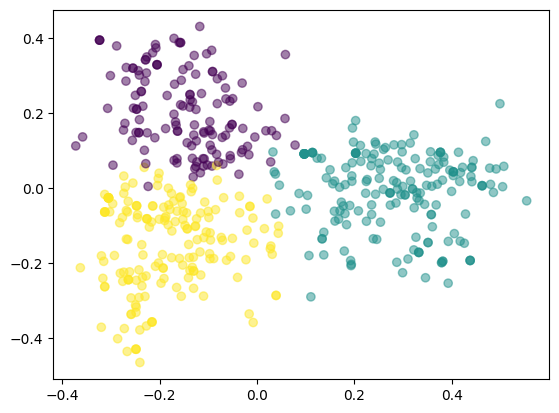

In [ ]:
plt.scatter(df_news_filtered['PCA_0'], df_news_filtered['PCA_1'], c=df_news_filtered['CLUSTER'], alpha=0.5)


#### Analyze the content of each cluster
- Add the kmeans cluster label to your news dataframe
- Print the content of each cluster and analyze it

In [ ]:
for i, row in df_news_filtered[df_news_filtered['CLUSTER'] == 0].iterrows():
    print(f"[{row['TICKER']:4s}] {row['EMBEDDED_TEXT']}")

[MMM ] 3M Company (MMM): “I Was Surprised” By The Organic Growth Rate, Says Jim Cramer
[ABT ] Revvity trims 2025 profit forecast as China policy changes hit diagnostics demand
[ADBE] Figma targets $18.8 billion valuation in US IPO after bumping up price range
[APD ] Green Hydrogen Boom Fizzles as Projects Collapse Worldwide
[ABNB] ‘I Prep for Survival’: OpenAI CEO Sam Altman Worries About The ‘Nonzero’ Chance The World Will End From ‘a Lethal Synthetic Virus’
[ALGN] Align Technology, Inc. (ALGN): A Bull Case Theory
[AEP ] PUCO Adopts AEP Ohio Data Center Proposal to Protect Consumers
[AON ] Company News for Jul 28, 2025
[APO ] Why Trump has turned the US economy into a Nike swoosh: Economist
[T   ] BofA Sees Upside in AT&T (T) With Bonus Depreciation Boost
[AVY ] Piper Sandler Boosts Price Target on Impinj (PI) to $140 Amid Sector Tailwinds
[AXON] Will Axon's AI-Driven Platform Continue to Enhance Community Safety?
[BAX ] Baxter recalls certain Novum pumps over issues tied to 79 injuri

This first cluster includes topics like uncertainty and risks in stocks, potentially more negative than the other clusters

In [ ]:
for i, row in df_news_filtered[df_news_filtered['CLUSTER'] == 1].iterrows():
    print(f"[{row['TICKER']:4s}] {row['EMBEDDED_TEXT']}")

[ABBV] Pre-Q2 Earnings: Is AbbVie Stock a Portfolio Must-Have?
[AES ] AES to Report Q2 Earnings: What's in Store for the Stock?
[A   ] Agilent Technologies' Q3 2025 Earnings: What to Expect
[AKAM] Akamai Technologies Earnings Preview: What to Expect
[ALLE] Allegion Second Quarter 2025 Earnings: Beats Expectations
[LNT ] Alliant Energy’s Quarterly Earnings Preview: What You Need to Know
[ALL ] Palomar (PLMR) Earnings Expected to Grow: Should You Buy?
[GOOGL] Microsoft has to hit its earnings out of the park: Opening Bid top takeaway
[GOOG] Microsoft has to hit its earnings out of the park: Opening Bid top takeaway
[AMCR] What to Expect From Amcor's Q4 2025 Earnings Report
[AIG ] Willis Towers Set to Report Q2 Earnings: What's in the Cards?
[AMT ] VICI Properties to Report Q2 Earnings: What to Expect From the Stock?
[AWK ] American Water Works to Release Q2 Earnings: What's in the Cards?
[AMP ] Earnings Beat: Ameriprise Financial, Inc. Just Beat Analyst Forecasts, And Analysts Have Been 

The news articles in this cluster appear to be mostly related to earnings reports and future stock expectations/price targets.

In [ ]:
for i, row in df_news_filtered[df_news_filtered['CLUSTER'] == 2].iterrows():
    print(f"[{row['TICKER']:4s}] {row['EMBEDDED_TEXT']}")

[AOS ] Here's Why A.O. Smith (AOS) is a Strong Value Stock
[ACN ] Accenture’s (ACN) Oversold Status May Offer a Smart Entry Point for Dividend Investors
[AMD ] AMD stock jumps on 3 catalysts, Boeing faces potential strike
[AFL ] 3 Reasons AFL is Risky and 1 Stock to Buy Instead
[ALB ] Albemarle (NYSE:ALB) Will Pay A Dividend Of $0.405
[ARE ] 2 Reliable Dividend Stocks With Yields Above 5% to Buy Now and Hold Forever
[MO  ] Why Altria (MO) is a Top Value Stock for the Long-Term
[AMZN] Stock market today: Dow, S&P 500, Nasdaq waver as Trump-EU trade deal kicks off huge week
[AEE ] Ameren (AEE) Earnings Expected to Grow: Should You Buy?
[AXP ] 'Haves and have-nots': The stock market thinks more consumers are reaching a breaking point
[AMGN] 2 Top Dividend Stocks to Buy Right Now and Hold Forever
[APH ] Don't Overlook Amphenol (APH) International Revenue Trends While Assessing the Stock
[ADI ] Analog Devices (ADI) Enters Oversold Territory with a Dividend Worth Watching
[APA ] APA (APA) St

This cluster appears to have news related to good performing stocks and buy recommendations.



## Question Section

Take time to reflect on what you've implemented and observed. Answer the following questions in a separate markdown cell or notebook file:

---

### Technical Understanding

#### 1️⃣ How might the choice of embedding model (e.g., MiniLM vs. a larger transformer) affect your clustering results and interpretation?

Larger and/or more complex models might be able to further understand the underlying meanings in the embedded text, providing a more accurate representation of the information conveyed by the news article.

---

#### 2️⃣ What would be the differences in embeddings if you used only the TITLE, only the SUMMARY, or the combination of both? How could you empirically test this?

Summaries should provide more granular and specific information, which could result in a clearer separation between clusters of news. This can be both good (by gaining more insight) or bad (by introducing more noise because of the greater amount of clusters to analyze). This effect would be greater when combining both title and summaries, since the information would be the most specific by then.

---

#### 3️⃣ In what situations would using a different dimensionality reduction method (e.g., t-SNE, UMAP) be preferable over PCA for visualization of embeddings?

t-SNE is generally better at visualizing clusters for human-analysis, and it performs very well in high dimensionality spaces with complex relationships like this one.

However, PCA is still very good when done as a preprocessing step, and can be used to first reduce dimensionality and then perform clustering on the lower-dimension space.


---

### Data Analysis and Interpretation

#### 4️⃣ Based on your cluster analysis, identify at least two potential challenges you faced in interpreting the clusters and propose strategies to address them.

In the generated clusters, even if there are overall topics discussed in each of them, there are items that may not be related to the given topic, but they were grouped as part of it because no other cluster would be appropriate. This can be mitigated by changing the number of clusters, with the caveat that more "noisy" categories might be created.

Another potential challenge is that there are some news articles that apply for multiple tickers. Because we are only embedding the titles, they are treated as the same. A possible solution would be to extract the portion of the news article discussing the specific ticker and add it to the embedding.

For example, there is a news article titled "Paramount, Disney, Warner Bros. Discovery: Media earnings preview" that applies for each of those companies. Instead of just embedding the title and/or summary, we could extract the paragraphs discussing each of those individual companies and add it to each of the respective embeddings.

---

#### 5️⃣ Did you observe any outliers in your 2D visualization? How would you identify and handle these outliers in a production pipeline?

At first glance, no visible outliers were found in the visualization.

However, a potential way to identify and handle potential outliers is to perform dimensionality reduction before clustering. This may be useful to reduce the "noise" from the high dimensional space and aid in finding the relationships between data points, resulting in more clearly defined cluster boundaries.

---

#### 6️⃣ If you could assign a 'label' or 'theme' to each cluster you obtained, what would they be? How confident are you in these assignments, and what could you do to validate them systematically?

As mentioned previously, the topics identified were:
- Risk and uncertainty
- Earning reports and expectations
- Good performing stocks and buying recommendations

A potential way to validate these groupings could be by comparing the embeddings with methods like cosine similarity. This can be applied to entries within a single cluster and its respective center to ensure similarity.

---

### Critical Thinking

#### 7️⃣ If news sentiment was incorporated into the analysis, how might this influence the clustering structure and interpretation of the clusters in a financial analysis context?

I believe sentiment would have a heavy weight in regards to how each news article is classified, potentially segregating into high-level clusters based on sentiment. These high level clusters could then potentially be further segregated into clusters based on the information of the news article.

---

#### 8️⃣ Discuss the limitations of using k-means clustering for news embeddings. What alternative clustering methods could address these limitations, and under what conditions would you prefer them?

Probably the main limitation for K-Means is that the number of clusters needs to be provided in advance. This means that either:
- If chosen arbitrarily, the number of clusters may not be optimal for the dataset
- Otherwise, further testing and experimentation is required to obtain the optimal number (as shown in this exercise by comparing silhouette scores)

An alternate clustering method that would overcome this challenge is mean-shift, which doesn't require the number of clusters to be provided by the user, but instead groups the data into "natural" clusters.

---

#### 9️⃣ How could the approach in this notebook be extended to analyze the potential impact of news clusters on stock price movements over time? Sketch a high-level pipeline you would implement to test this.

I would obtain the embeddings using the approach from this exercise and combine it with sentiment analysis and technical analysis.

---

#### 10️⃣ Imagine your clustering shows clear groups of news, but your downstream task (e.g., prediction of stock movement) does not improve. What might explain this disconnect between clear clusters and predictive utility?

Clusters may be discussing common topics, but their sentiment and potential implications to the stock may not be the same.

For example, there are multiple news about upcoming earnings reports. If we embed the titles only, it makes sense that they should be grouped together. However, this doesn't account for whether the stock is expected to meet, fall below or exceed expecations; this would require adding more context from the rest of the article (as opposed to just the title).

Also, some articles may be discussing developing news stories without a clear conclusion, so the meaning derived from the embeddings will be affected by the inherent uncertainty, impacting the predicting capability.